In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from scipy.stats import multivariate_normal as mvn
import nltk
import os
import random

import string

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import os, sys, email,re


In [2]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/DataSets/emails.csv',nrows = 35000)
df.shape

(35000, 2)

In [5]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


# Main Analysis Starts Here
## Use the Email module to extract raw text

In [6]:
emails = list(map(email.parser.Parser().parsestr,df['message']))

headings  = emails[0].keys()

for key in headings:
    df[key] = [doc[key] for doc in emails]

df

,file,message,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,blair-l/meetings/581.,Message-ID: <6901665.1075853038085.JavaMail.ev...,<6901665.1075853038085.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",outlook.team@enron.com,None,TMS Weekly Mtg. Conference room EB4102,1.0,text/plain; charset=us-ascii,7bit,Outlook Migration Team <Outlook Migration Team...,,,,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings",Blair-L,LBLAIR (Non-Privileged).pst
34996,blair-l/meetings/582.,Message-ID: <32175908.1075853038108.JavaMail.e...,<32175908.1075853038108.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",outlook.team@enron.com,None,TMS Weekly Mtg. Conference room EB4102,1.0,text/plain; charset=us-ascii,7bit,Outlook Migration Team <Outlook Migration Team...,,,,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings",Blair-L,LBLAIR (Non-Privileged).pst
34997,blair-l/meetings/583.,Message-ID: <17265410.1075853038130.JavaMail.e...,<17265410.1075853038130.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",outlook.team@enron.com,None,TMS Weekly Mtg. Conference room EB4102,1.0,text/plain; charset=us-ascii,7bit,Outlook Migration Team <Outlook Migration Team...,,,,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings",Blair-L,LBLAIR (Non-Privileged).pst
34998,blair-l/meetings/584.,Message-ID: <1028310.1075853038154.JavaMail.ev...,<1028310.1075853038154.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",outlook.team@enron.com,None,TMS Weekly Mtg. Conference room EB4102,1.0,text/plain; charset=us-ascii,7bit,Outlook Migration Team <Outlook Migration Team...,,,,"\LBLAIR (Non-Privileged)\Blair, Lynn\Meetings",Blair-L,LBLAIR (Non-Privileged).pst


In [7]:
def get_raw_text(emails):
    email_text = []
    for email in emails.walk():
        if email.get_content_type() == 'text/plain':
            email_text.append(email.get_payload())
    return ''.join(email_text)

df['body'] = list(map(get_raw_text, emails))
df.head()
df['user'] = df['file'].map(lambda x: x.split('/')[0])

In [8]:
print('Total number of emails: %d' %len(df))
print('------------')
print('Number of unique received: %d '%df['To'].nunique())
print('------------')
print('Number of unique Sent: %d '%df['From'].nunique())

Total number of emails: 35000
------------
Number of unique received: 4926 
------------
Number of unique Sent: 2151 


In [9]:
df['Date'].map(lambda x : int(x.split()[3]))

0        2001
1        2001
2        2000
3        2000
4        2000
         ... 
34995    2001
34996    2001
34997    2001
34998    2001
34999    2001
Name: Date, Length: 35000, dtype: int64

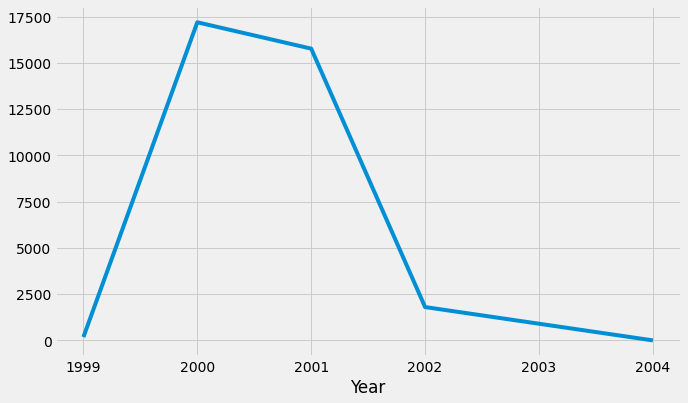

In [10]:
df['Month'] = df['Date'].map(lambda x : x.split()[2])
df['Year'] = df['Date'].map(lambda x : int(x.split()[3]))
df['Day'] = df['Date'].map(lambda x : x.split()[0][:-1])

indices = (df['Year'] > 1995) & (df['Year'] <= 2004)
plt.figure(figsize = (10,6))
figure1 = df.loc[indices].groupby('Year')['body'].count().plot()

### Most frequent Senders and receivers of Emails

In [11]:
top_10_frequent = df.groupby('user')['file'].count().sort_values(ascending = False)[:30]
top_10_frequent

user
beck-s        11830
bass-e         7823
arnold-j       4898
allen-p        3034
baughman-d     2760
blair-l        1879
badeer-r        877
benson-r        767
arora-h         654
bailey-s        478
Name: file, dtype: int64

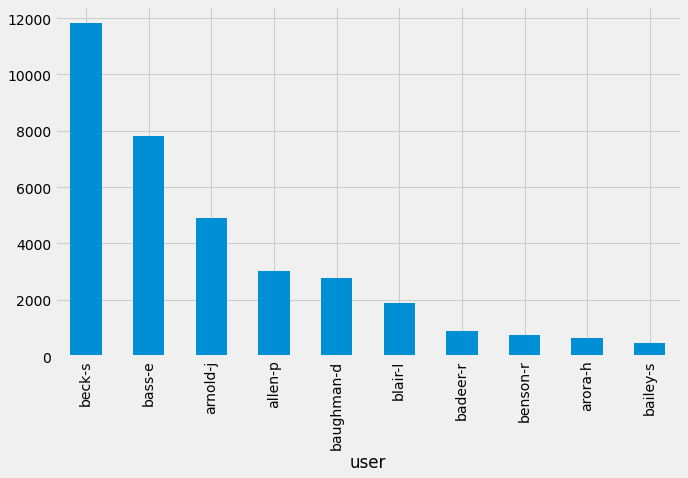

In [12]:
plt.figure(figsize = (10,6))
top_10_frequent.plot(kind = 'bar')

## Check whether emails were to a single person or multiple people

In [13]:
def split_data(data):
    if data is not None:
        temp = data.split(',')
        if len(temp) == 1:
            return 'Direct'
        else:
            return 'Multiple'
    else:
        return 'Empty'
df['Direct_or_multi'] = df['To'].apply(split_data)

## Top 10 most frequent emailers


In [14]:
df.groupby('user')['Direct_or_multi'].value_counts().sort_values(ascending=False)[:15]

user        Direct_or_multi
beck-s      Direct             7595
bass-e      Direct             5900
arnold-j    Direct             4354
beck-s      Multiple           3960
allen-p     Direct             2631
bass-e      Multiple           1738
baughman-d  Direct             1327
            Multiple           1311
blair-l     Empty               723
            Multiple            656
badeer-r    Direct              544
arora-h     Direct              505
blair-l     Direct              500
arnold-j    Multiple            408
allen-p     Multiple            340
Name: Direct_or_multi, dtype: int64

In [15]:
df['body'][9]

'---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/16/2000 \n01:42 PM ---------------------------\n\n\n"Buckner, Buck" <buck.buckner@honeywell.com> on 10/12/2000 01:12:21 PM\nTo: "\'Pallen@Enron.com\'" <Pallen@Enron.com>\ncc:  \nSubject: FW: fixed forward or other Collar floor gas price terms\n\n\nPhillip,\n\n> As discussed  during our phone conversation, In a Parallon 75 microturbine\n> power generation deal for a national accounts customer, I am developing a\n> proposal to sell power to customer at fixed or collar/floor price. To do\n> so I need a corresponding term gas price for same. Microturbine is an\n> onsite generation product developed by Honeywell to generate electricity\n> on customer site (degen). using natural gas. In doing so,  I need your\n> best fixed price forward gas price deal for 1, 3, 5, 7 and 10 years for\n> annual/seasonal supply to microturbines to generate fixed kWh for\n> customer. We have the opportunity to sell customer kWh \'s using\n> micro

## Clean the subject columns

In [16]:
def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        # removes punctuation 
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        
        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'


df['Subject_new'] = df['Subject'].apply(clean_column)
df['body_new'] = df['body'].apply(clean_column)

In [17]:
df[['body','body_new']].head(10)

,body,body_new
0,Here is our forecast\n\n,here is our forecast
1,Traveling to have a business meeting takes the...,traveling to have a business meeting takes the...
2,test successful. way to go!!!,test successful way to go
3,"Randy,\n\n Can you send me a schedule of the s...",randy can you send me a schedule of the sala...
4,Let's shoot for Tuesday at 11:45.,lets shoot for tuesday at
5,"Greg,\n\n How about either next Tuesday or Thu...",greg how about either next tuesday or thursd...
6,Please cc the following distribution list with...,please cc the following distribution list with...
7,any morning between 10 and 11:30,any morning between and
8,1. login: pallen pw: ke9davis\n\n I don't thi...,login pallen pw kedavis i dont think these ...
9,---------------------- Forwarded by Phillip K ...,forwarded by phillip k allenhouect on pm ...


In [18]:
df[['Subject','Subject_new']].head(10)

,Subject,Subject_new
0,,
1,Re:,
2,Re: test,test
3,,
4,Re: Hello,hello
5,Re: Hello,hello
6,,
7,Re: PRC review - phone calls,prc review phone calls
8,Re: High Speed Internet Access,high speed internet access
9,FW: fixed forward or other Collar floor gas pr...,fw fixed forward or other collar floor gas pri...


In [20]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

## Visualise Email Subject

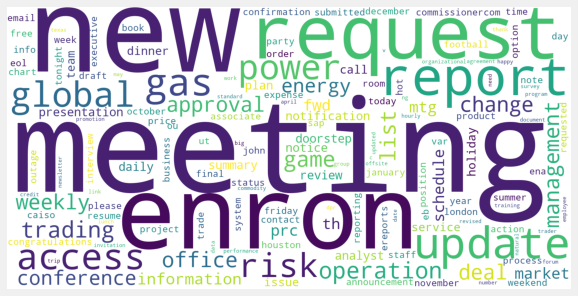

In [21]:
wordcloud = WordCloud(
              collocations = False,
              width=1600, height=800,
              background_color='white',
              stopwords=stopwords,
              max_words=150,
              random_state=42).generate(' '.join(df['Subject_new']))
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## TF-IDF tranformation for K-means algorithm

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = df['body_new']

tf_idf_vectorizor = TfidfVectorizer(stop_words = stopwords, max_features = 5000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'fw', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaron,abc,abcsubstringabclength,abel,abelhouectect,ability,able,absence,absolutely,ac,...,youve,ypc,yvette,zadow,zdnet,zero,zhiyong,zip,zipper,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#@title
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))




# K-means Implementation

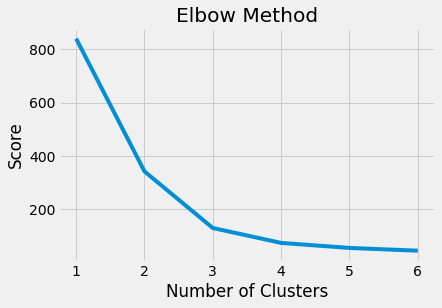

In [23]:
from sklearn.cluster import KMeans

number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

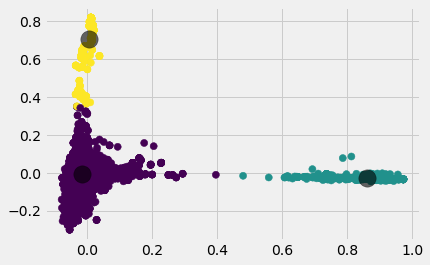

In [24]:
n_clusters = 3
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= n_clusters, max_iter=600)
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

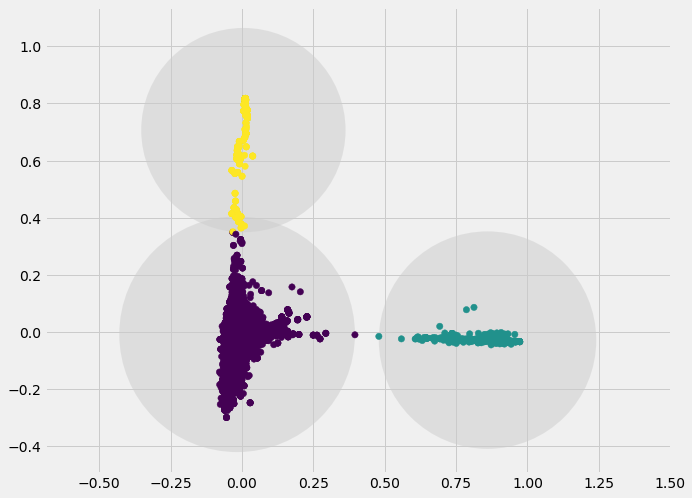

In [25]:
plt.figure(figsize = (10,8))
from scipy.spatial.distance import cdist
def plot_kmeans(kmeans, X, n_clusters=3, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
plot_kmeans(kmeans, Y_sklearn)

## Gaussian Mixuture Model Implementation

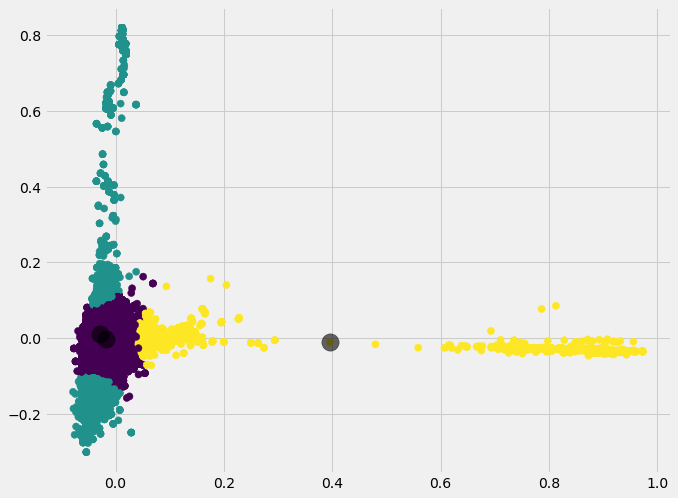

In [26]:
from sklearn.mixture import GaussianMixture
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction_gmm ,s=50, cmap='viridis', zorder=1)
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w*.75)

# Optimal Clusters

In [32]:
#@title
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

def optimal_cluster(x):
  for n_clusters in range_n_clusters:
      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax1.set_ylim([0, len(Y_sklearn) + (n_clusters + 1) * 10])

      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.
      if x == "K" or x == "k" :
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
      elif x=="G"or x=="g" :
        clusterer = GaussianMixture(n_components=n_clusters, random_state=42)

      cluster_labels = clusterer.fit_predict(Y_sklearn)

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_score(Y_sklearn, cluster_labels)
      print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

      silhouette_avg_n_clusters.append(silhouette_avg)
      # Compute the silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(Y_sklearn, cluster_labels)

      y_lower = 10
      for i in range(n_clusters):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

          # Label the silhouette plots with their cluster numbers at the middle
          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # Compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples

      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # 2nd Plot showing the actual clusters formed
      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      ax2.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

      # Labeling the clusters
      if x == "K" or x == "k" :
        centers = clusterer.cluster_centers_
      elif x=="G"or x=="g" :
        centers = np.zeros((n_clusters,2))
        for i in range(n_clusters):
          density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
          centers[i, :] = Y_sklearn[np.argmax(density)]
      
      # Draw white circles at cluster centers
      ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

      for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')

  plt.show()


  style.use("fivethirtyeight")
  plt.plot(range_n_clusters, silhouette_avg_n_clusters)
  plt.xlabel("Number of Clusters (k)")
  plt.ylabel("silhouette score")
  plt.show()

K-means Optimal Clusters
For n_clusters = 2 The average silhouette_score is : 0.9113644487980935
For n_clusters = 3 The average silhouette_score is : 0.9093474470055816
For n_clusters = 4 The average silhouette_score is : 0.5803769159722535
For n_clusters = 5 The average silhouette_score is : 0.4046816813624297
For n_clusters = 6 The average silhouette_score is : 0.41370332850465064


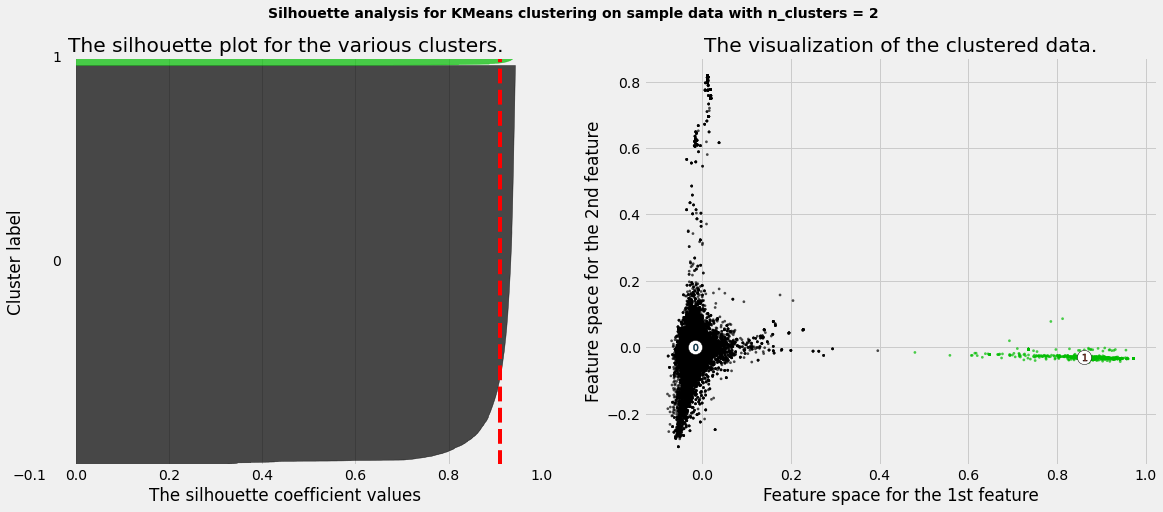

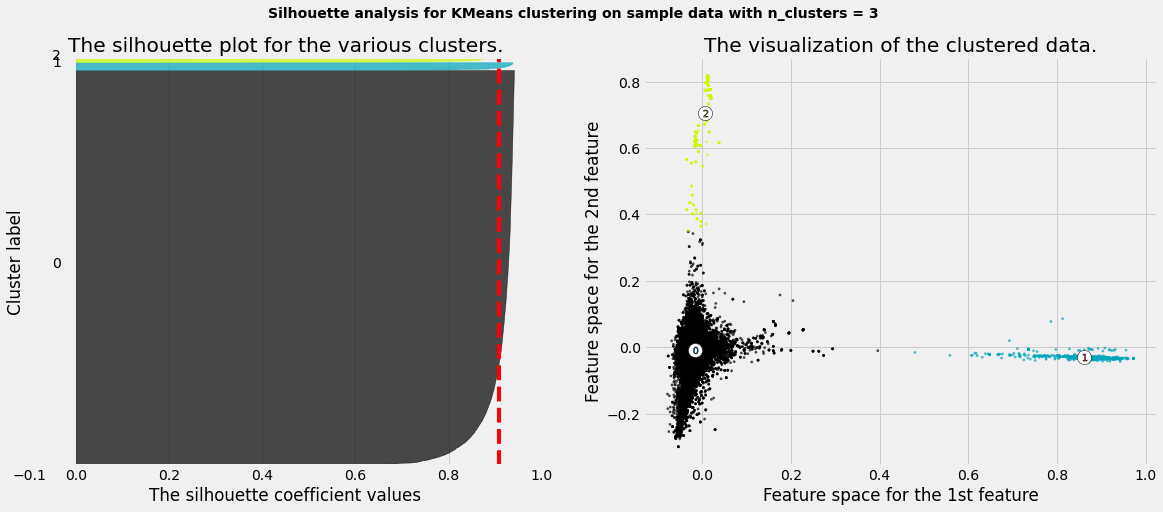

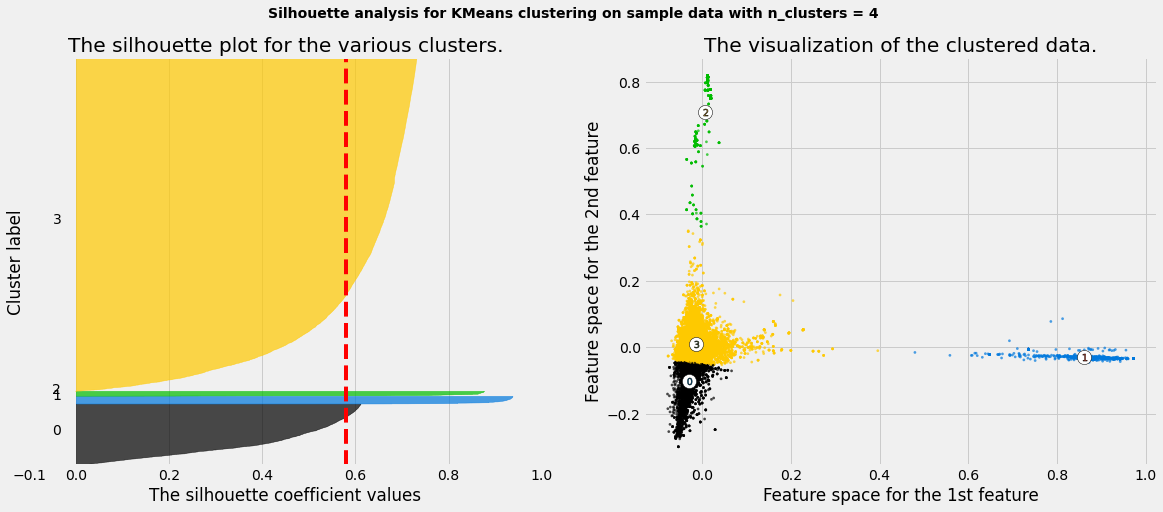

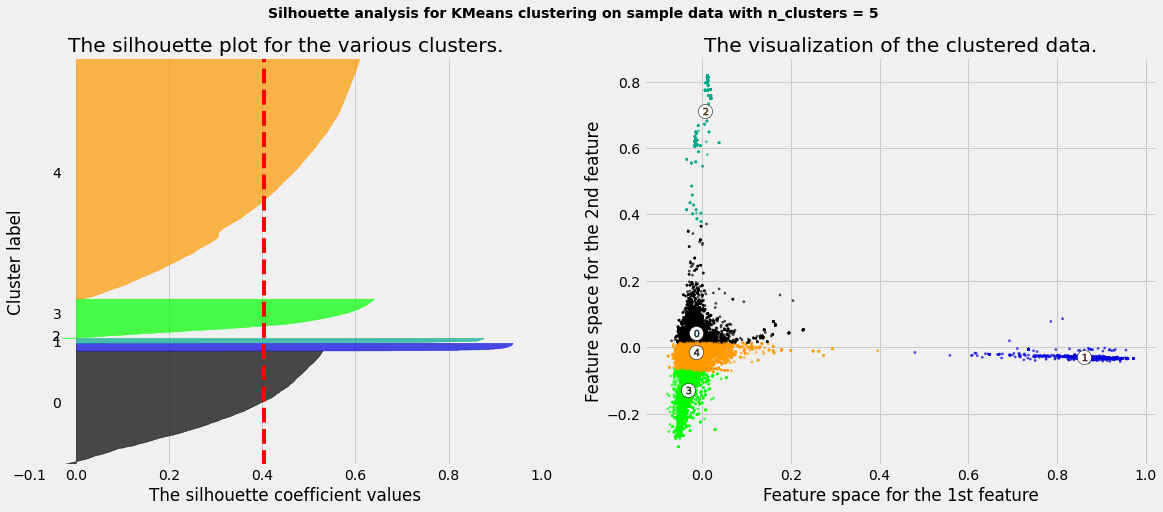

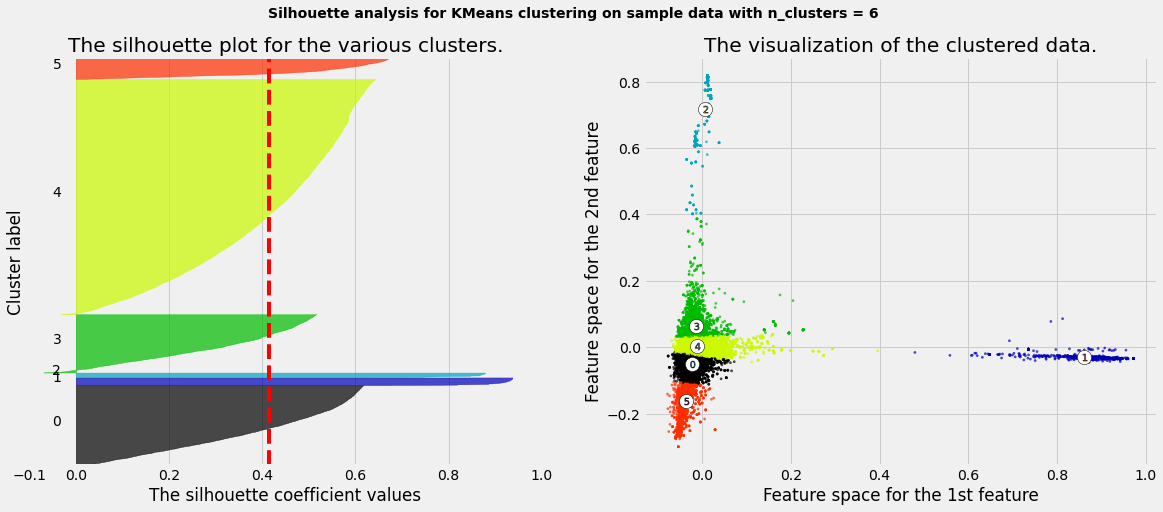

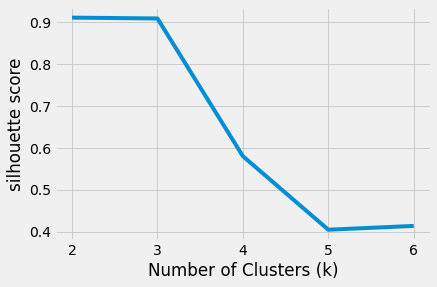

In [33]:
#@title
print("K-means Optimal Clusters")
optimal_cluster("K")

In [ ]:
print("Gaussian Mixuture Model Optimal Clusters")
optimal_cluster("G")





# Extracting top features

In [35]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) 
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) 
        sorted_means = np.argsort(x_means)[::-1][:n_feats] 
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


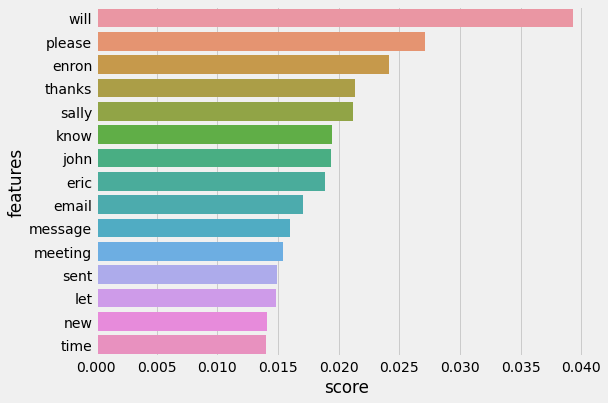

In [36]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

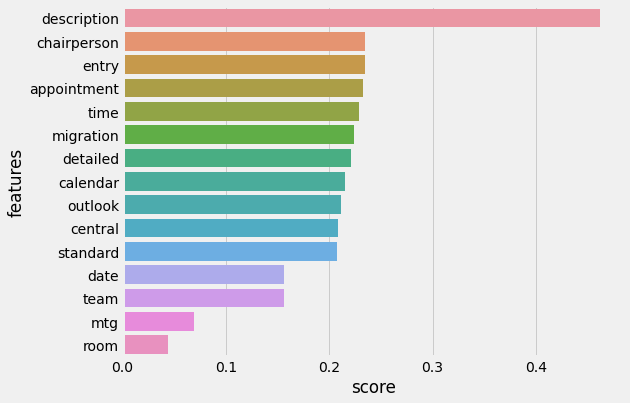

In [37]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

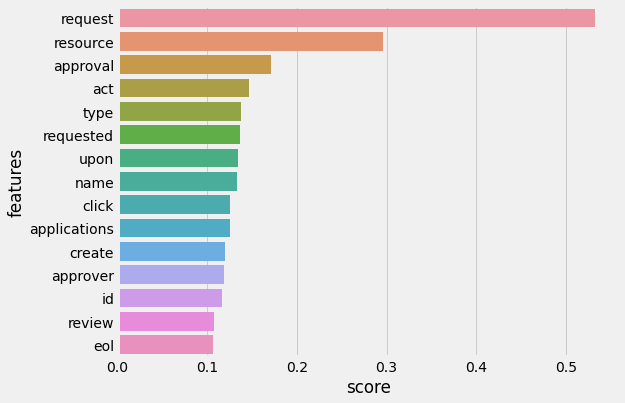

In [38]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

In [39]:
dfs[2]

,features,score
0,request,0.532038
1,resource,0.295784
2,approval,0.171297
3,act,0.146134
4,type,0.137452
5,requested,0.135967
6,upon,0.134383
7,name,0.132748
8,click,0.125601
9,applications,0.125250


In [41]:
for i, df in enumerate(dfs):
    df.to_csv('df_'+str(i)+'.csv')

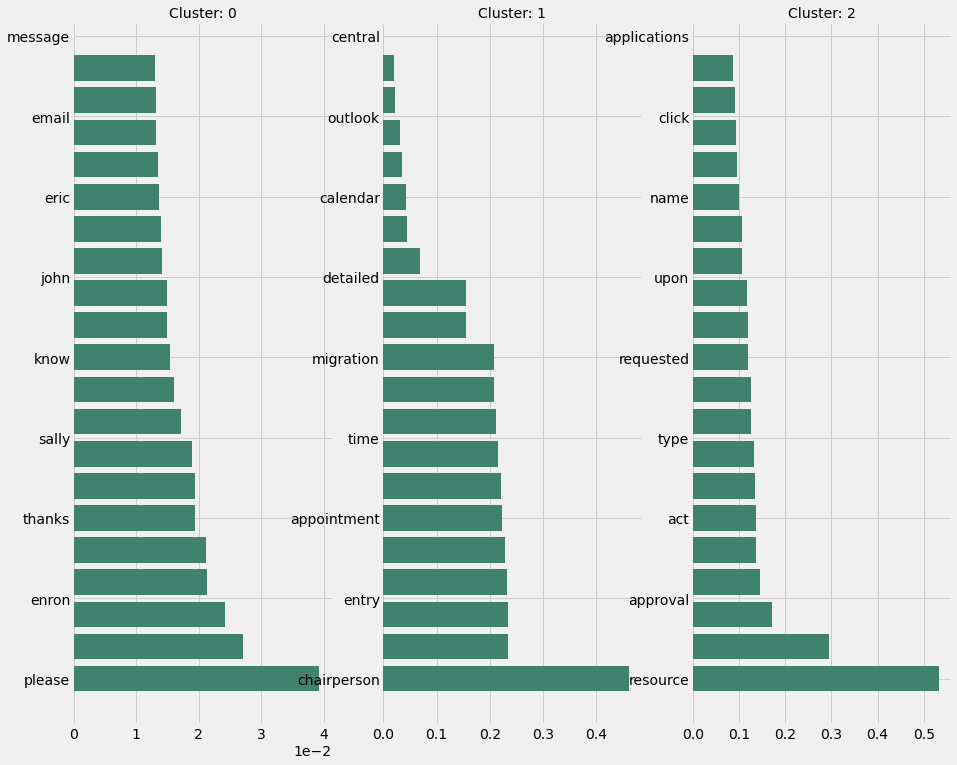

In [42]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)